In [3]:
from __future__ import print_function, division

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from pathlib import Path
import imageio
import numpy as np
%matplotlib inline
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy import ndimage
from matplotlib.colors import ListedColormap
from skimage.feature import peak_local_max
from skimage import measure
import os
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import random
import os
import sys
import random
import warnings
from tqdm import tqdm
import tensorflow as tf

import pandas as pd

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.layers.core import  Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'SampleTraining/sample_train/'
TEST_PATH = '../Machinelearning/assignment2/stage1_test/'

# warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = int(500)


/home/emma/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Get images

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]

In [3]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


# Metric

In [4]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# MLP, pixel classification 

In [5]:
# # reshape to do classification by pixel 
# Xx_train = X_train.reshape(100, 256*256, 3) #images
# Yy_train = Y_train.reshape(100, 256*256, 1) #masks

mlp = Sequential()

mlp.add(Dense(256, activation='relu', input_shape = (256*256,3), bias = True))
mlp.add(Dropout(0.25))
mlp.add(Dense(256, activation='relu', bias = True))
mlp.add(Dropout(0.25))
mlp.add(Dense(256, activation = 'relu', bias = True))
mlp.add(Dropout(0.25))
mlp.add(Dense(1, activation='sigmoid')) 

mlp.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics = [mean_iou])
mlp.summary()
# mlp.fit(Xx_train, Yy_train,
#         batch_size=16, 
#         epochs=2,
#         verbose=1,
#         validation_split=0.1,)

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, use_bias=True, input_shape=(65536, 3), activation="relu")`
  import sys
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, use_bias=True, activation="relu")`
  if __name__ == '__main__':
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, use_bias=True, activation="relu")`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536, 256)        1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 65536, 256)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 65536, 256)        65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 65536, 256)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 65536, 256)        65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 65536, 256)        0         
_________________________________________________________________
dense_4 (Dense)              (None, 65536, 1)          257       
Total para

In [74]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-trainingmlp.h5', verbose=1, save_best_only=True)
results = mlp.fit(Xx_train, Yy_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 90 samples, validate on 10 samples
Epoch 1/10
90/90 [==============================] - 112s 1s/step - loss: 1.9490 - mean_iou: 0.2037 - val_loss: 2.5263 - val_mean_iou: 0.0916

Epoch 00001: val_loss improved from inf to 2.52630, saving model to model-dsbowl2018-trainingmlp.h5
Epoch 2/10
90/90 [==============================] - 115s 1s/step - loss: 1.8773 - mean_iou: 0.0634 - val_loss: 2.2090 - val_mean_iou: 0.0433

Epoch 00002: val_loss improved from 2.52630 to 2.20903, saving model to model-dsbowl2018-trainingmlp.h5
Epoch 3/10
90/90 [==============================] - 114s 1s/step - loss: 1.3819 - mean_iou: 0.0376 - val_loss: 0.5886 - val_mean_iou: 0.0596

Epoch 00003: val_loss improved from 2.20903 to 0.58865, saving model to model-dsbowl2018-trainingmlp.h5
Epoch 4/10
90/90 [==============================] - 120s 1s/step - loss: 0.8872 - mean_iou: 0.0603 - val_loss: 0.6996 - val_mean_iou: 0.0558

Epoch 00004: val_loss did not improve
Epoch 5/10
90/90 [========================

In [68]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(Xx_train[:int(Xx_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(Xx_train[int(Xx_train.shape[0]*0.9):], verbose=1)

NameError: name 'Xx_train' is not defined

In [9]:
preds_train = preds_train.reshape(90,256,256,1)
preds_val = preds_val.reshape(10, 256, 256, 1)

Text(0.5,1,'predicition')

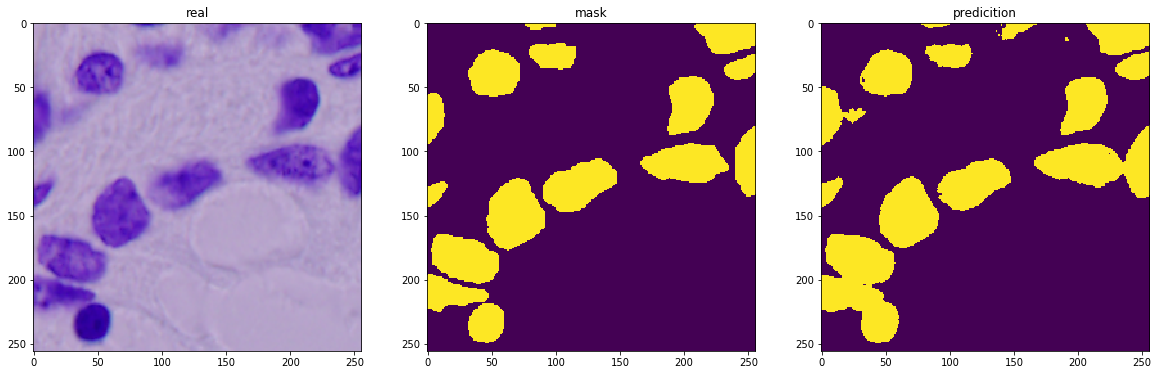

In [13]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_train))

plt.subplot(1,3,1)
plt.imshow(X_train[ix])
plt.title('real')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[ix]))
plt.title('mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_train[ix]>0.5))
plt.title('predicition')

Text(0.5,1,'predicition')

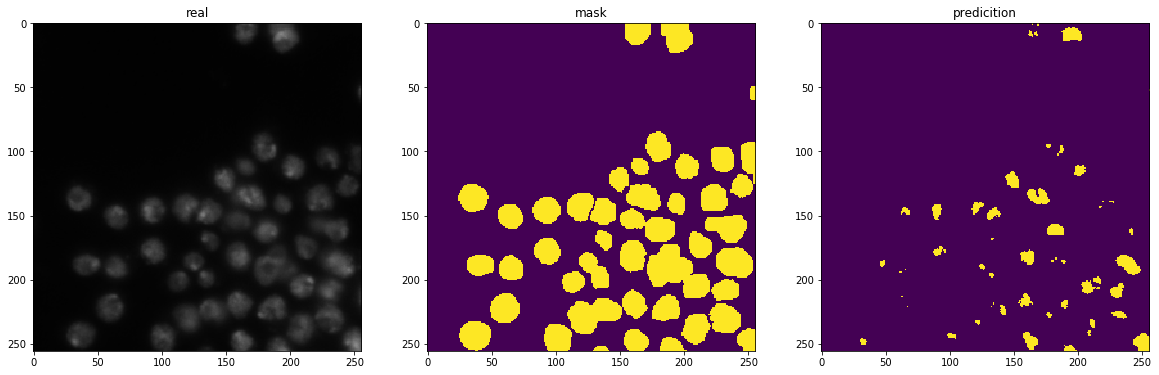

In [18]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_val))
# ix = 0
plt.subplot(1,3,1)
plt.imshow(X_train[90 + ix])
plt.title('real')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[90 +ix]))
plt.title('mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_val[ix]>0.5))
plt.title('predicition')

# Feature engineering

# Image Augmentation

# Cutting images up - split every image into 256 subimages 

Work on MLP on smaller dimensional images

In [11]:
cut_im = np.zeros((256,*len(train_ids) 16, 16, 3), dtype=np.uint8)
cut_masks = np.zeros((256*len(train_ids), 16, 16, 1), dtype=np.bool)
# cut_masks = []
for index, im in enumerate(X_train):
    sub_im = []
    sub_mask = []
    for i in range(16):
        for j in range(16):
            new_im = X_train[index][16*i:16*(i+1), 16*j:16*(j+1)]
            new_mask = Y_train[index][16*i:16*(i+1), 16*j:16*(j+1)]
            sub_im.append(new_im)
            sub_mask.append(new_mask)
    cut_im.append(sub_im)
    cut_masks.append(sub_mask)

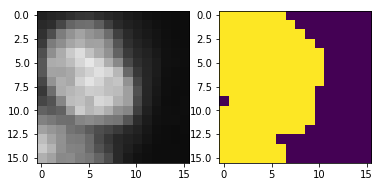

In [22]:
plt.subplot(1,2,1)
plt.imshow(cut_im[0][5])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(cut_masks[0][5]))

In [62]:
def reverse_FE(arrofarr):
    Predicted_image = []
    for m in range(len(arrofarr)):
        reshap = []
        for image in arrofarr[m]:
            reshap.append(image.reshape(16,16,1))
        Final_im = np.zeros(( IMG_HEIGHT, IMG_WIDTH, 1))
        count = 0
        for i in range(16):
            for j in range(16):
                Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
                count +=1
        Predicted_image.append(Final_im)
    return Predicted_image

# Testing data and RLE

In [6]:
TRAINING_PATH = 'stage1_train/'
TESTING_PATH = 'stage1_test/'

In [7]:
training_ids = next(os.walk(TRAINING_PATH))[1]
testing_ids = next(os.walk(TESTING_PATH))[1]

In [8]:
X_training = np.zeros((len(training_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_training = np.zeros((len(training_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(training_ids), total=len(training_ids)):
    path = TRAINING_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_training[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_training[n] = mask

# Get and resize test images
X_test = np.zeros((len(testing_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(testing_ids), total=len(testing_ids)):
    path = TESTING_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:09<00:00,  5.19it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 63.72it/s]


## MLP

In [10]:
Xx_training = X_training.reshape(len(X_training), 256*256, 3) #images
Yy_training = Y_training.reshape(len(Y_training), 256*256, 1) #masks

mlp2 = Sequential()

mlp2.add(Dense(256, activation='relu', input_shape = (256*256,3)))
mlp2.add(Dropout(0.25))
mlp2.add(Dense(128, activation='relu'))
mlp2.add(Dropout(0.25))
mlp2.add(Dense(128, activation = 'relu'))
mlp2.add(Dropout(0.25))
mlp2.add(Dense(1, activation='sigmoid')) 

mlp2.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics = [mean_iou])
mlp2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 65536, 256)        1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 65536, 256)        0         
_________________________________________________________________
dense_10 (Dense)             (None, 65536, 128)        32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 65536, 128)        0         
_________________________________________________________________
dense_11 (Dense)             (None, 65536, 128)        16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 65536, 128)        0         
_________________________________________________________________
dense_12 (Dense)             (None, 65536, 1)          129       
Total para

# Include early stopping before reaching 20 epochs

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-extralayer.h5', verbose=1, save_best_only=True)
results = mlp2.fit(Xx_training, Yy_training, validation_split=0.1, batch_size=16, epochs=20, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 392s 650ms/step - loss: 0.8478 - mean_iou: 0.0758 - val_loss: 0.5621 - val_mean_iou: 0.0764

Epoch 00001: val_loss improved from inf to 0.56208, saving model to model-dsbowl2018-extralayer.h5
Epoch 2/20
603/603 [==============================] - 370s 613ms/step - loss: 0.5376 - mean_iou: 0.0754 - val_loss: 0.4866 - val_mean_iou: 0.0723

Epoch 00002: val_loss improved from 0.56208 to 0.48658, saving model to model-dsbowl2018-extralayer.h5
Epoch 3/20
603/603 [==============================] - 371s 616ms/step - loss: 0.4006 - mean_iou: 0.0699 - val_loss: 0.3196 - val_mean_iou: 0.0711

Epoch 00003: val_loss improved from 0.48658 to 0.31956, saving model to model-dsbowl2018-extralayer.h5
Epoch 4/20
603/603 [==============================] - 378s 626ms/step - loss: 0.3013 - mean_iou: 0.0707 - val_loss: 0.2638 - val_mean_iou: 0.0708

Epoch 00004: val_loss improved from 0.31956 to 0.26380, saving

# Plot Epoch Curves

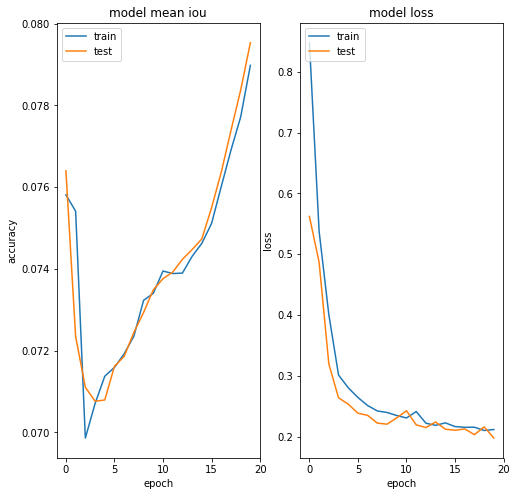

FileNotFoundError: [Errno 2] No such file or directory: 'logs.npy'

In [14]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['mean_iou'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['mean_iou'])
    plt.plot(history.history['val_mean_iou'])
    plt.title('model mean iou')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
plot_learning_curve(results)
plt.show()
plotKerasLearningCurve()
plt.show()

# Predictions

In [15]:
X_test1 = X_test.reshape(len(X_test), 256*256, 3)

In [16]:
model = load_model('model-dsbowl2018-extralayer.h5', custom_objects={'mean_iou': mean_iou})

preds_training = model.predict(Xx_training[:int(Xx_training.shape[0]*0.9)], verbose=1)
preds_training = preds_training.reshape(603, 256, 256, 1)

preds_valid = model.predict(Xx_training[int(Xx_training.shape[0]*0.9):], verbose=1)
preds_valid = preds_valid.reshape(67, 256, 256, 1)

preds_test = model.predict(X_test1, verbose=1)
preds_test = preds_test.reshape(len(X_test1), 256, 256, 1)

65/65 [==============================] - 11s 166ms/step


In [43]:
5898240/(256*256)

90.0

In [19]:
pred_test_sub = (preds_test < 0.5).astype(np.uint8)
preds_test_upsampled1 = []
for i in range(len(pred_test_sub)):
    preds_test_upsampled1.append(resize(np.squeeze(pred_test_sub[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

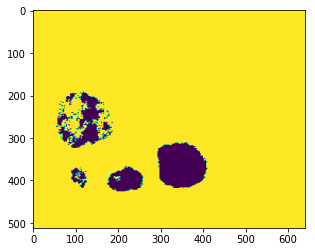

In [20]:
plt.imshow(preds_test_upsampled1[0])

# Plot the validation 

Text(0.5,1,'Predicted Mask')

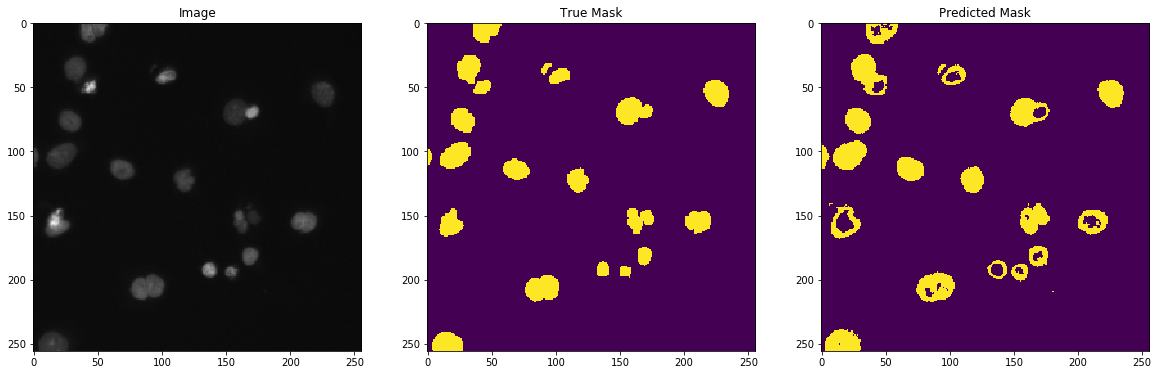

In [21]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_valid))

plt.subplot(1,3,1)
plt.imshow(X_training[ix])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_training[ix]>0.5))
plt.title('Predicted Mask')

Text(0.5,1,'Predicted Mask')

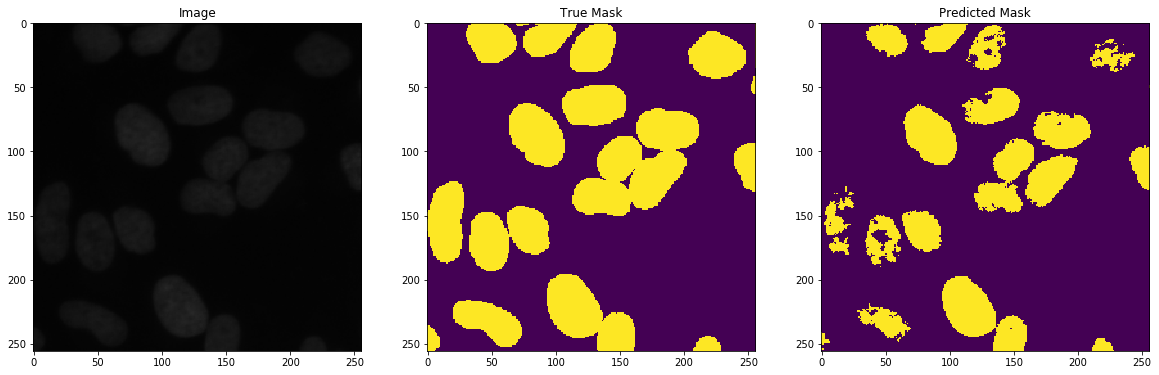

In [23]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_valid))

plt.subplot(1,3,1)
plt.imshow(X_training[ix+603])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix+603]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_valid[ix]>0.5))
plt.title('Predicted Mask')

Text(0.5,1,'Predicted Mask')

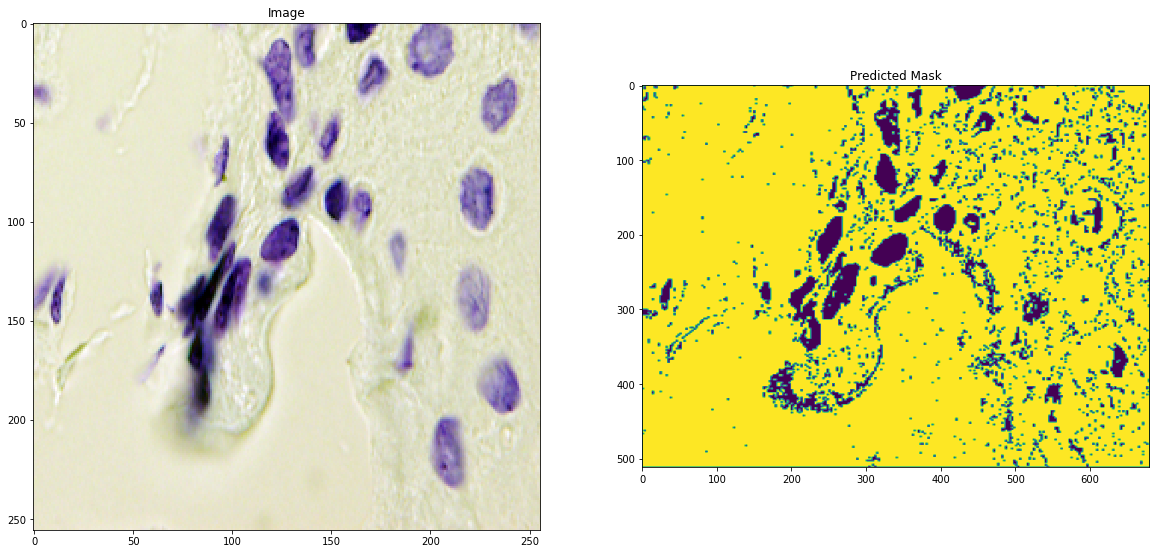

In [33]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_test))

plt.subplot(1,2,1)
plt.imshow(X_test[ix])
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(preds_test_upsampled1[ix])
plt.title('Predicted Mask')

In [34]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


In [35]:
new_test_ids = []
rles = []
for n, id_ in enumerate(testing_ids):
    rle = list(prob_to_rles(preds_test_upsampled1[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [36]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018moredropout.csv', index=False)